# Decision Trees

Un extrait quasi-inchangé du livre d'Aurélien Géron

## Intro

Decision Trees are versatile Machine Learning algorithms that can perform both classification and regression tasks, and even multioutput tasks. They are very powerful algorithms, capable of fitting complex datasets.  Decision Trees are also the fundamental components of Random Forests, which are among the most powerful Machine Learning algorithms available today. 

* We will start by discussing how to train, visualize, and make predictions with Decision Trees.
* Then we will go through the CART training algorithm used by Scikit-Learn, and we will discuss how to regularize trees and use them for regression tasks. 
* Finally, we will discuss some of the limitations of Decision Trees 

### Installation de graphviz

graphviz est une bibliothèqur pour visualiser les graphes. 

In [0]:
"on installe la bibliothèqye"
!apt-get install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [0]:
"on installe le wrapper python"
!pip install graphviz

Remarque: quand j'ai voulu tester d'installer `graphiz` en local (donc pas avec colab), j'ai du changer des droits d'accès:
      
      sudo chmod 777 /usr/local/include
   
(c'était réclamé dans le message d'erreur)

### The top-cell

In [0]:
%reset -f
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import graphviz

import sklearn.linear_model
import sklearn.datasets
import sklearn.tree

## Classification

### Training and Visualizing a Decision Tree

To understand Decision Trees, let’s just build one and take a look at how it makes predictions. The following code trains a DecisionTreeClassifier on the iris dataset.

In [0]:
iris = sklearn.datasets.load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = sklearn.tree.DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

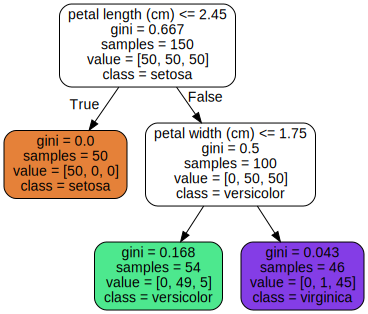

In [0]:
dot_data =sklearn.tree.export_graphviz(
        tree_clf,
        out_file=None, #vous pouvez aussi mettre un chemin d'accès pour que les données du graph soient sauvegardées
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

graph = graphviz.Source(dot_data) 
graph

***A vous:*** Observez l'arbre ci-dessus. Supposez que vous avez un iris tel que

* petal length = 3
* petal width = 1

Dans quel espèce faut-il le classer? 

***Note:*** One of the many qualities of Decision Trees is that they require very little data preparation. In particular, they don’t require feature scaling or centering at all.

Here is the signification of the labels on the tree:

*   `samples`:  counts how many training instances it applies to. For example, 100 training instances have a petal length greater than 2.45 cm (depth 1, right), among which 54 have a petal width smaller than 1.75 cm (depth 2, left). 
*  `value`: attribute tells you how many training instances of each class this node applies to: for example, the bottom-right node applies to 0 Iris-Setosa, 1 Iris-Versicolor, and 45 Iris-Virginica.
*  `gini`: measures the impurity:  For the node $i$, its Gini index is given by:
$$
G_i = 1- \sum_k p^2_{i,k}
$$
where $p_{i,k}$ is the ratio of class $k$ instances among the training instances in the $i$-th node.

***A vous:*** Vérifiez $(2\heartsuit)$ le calcul des différents indices de Gini. Utilisez python comme une calculatrice. 

***NOTE:*** Scikit-Learn uses the CART algorithm, which produces only binary trees: nonleaf nodes always have two children (i.e., questions only have yes/no answers). However, other algorithms such as ID3 can produce Decision Trees with nodes that have more than two children.


### Decision boundaries

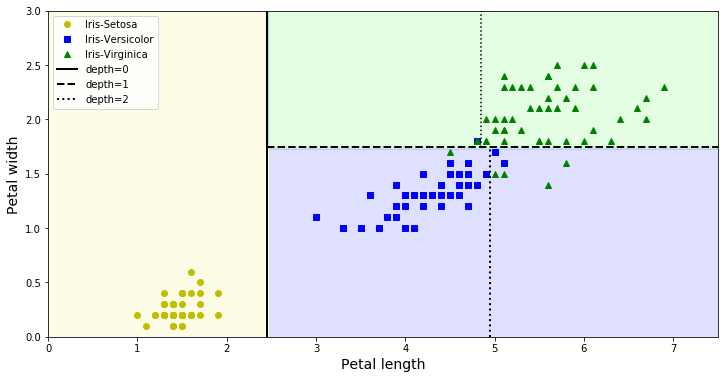

In [0]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(12, 6))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2,label="depth=0")
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2,label="depth=1")
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2,label="depth=2")
plt.plot([4.85, 4.85], [1.75, 3], "k:")
plt.legend();

###  Model interpretation: white box versus blackbox

As you can see Decision Trees are fairly intuitive and their decisions are easy to interpret. Such models are often called white box models. In contrast, as we will see, Random Forests or neural networks are generally considered black box models. They make great predictions, and you can easily check the calculations that they performed to make these predictions; nevertheless, it is usually hard to explain in simple terms why the predictions were made. For example, if a neural network says that a particular person appears on a picture, it is hard to know what actually contributed to this prediction: did the model recognize that person’s eyes? Her mouth? Her nose? Her shoes? Or even the couch that she was sitting on? Conversely, Decision Trees provide nice and simple classification rules that can even be applied manually if need be (e.g., for flower classification).

### Estimating Class Probabilities

Suppose you have found a flower whose petals are 5 cm long and 1.5 cm wide. Let's predict its specie:

In [0]:
print(tree_clf.predict([[5, 1.5]]))
print(tree_clf.predict_proba([[5, 1.5]]))

[1]
[[0.         0.90740741 0.09259259]]


***A vous:*** Expliquez $(1\heartsuit)$ comment sont calculées les probabilités. Quel $(1\heartsuit)$ est le gros défaut de ce calcul de probabilité. **Aide:** Observez les "decision boundary". Que se passe-t-il prèt des frontières?

###  The CART Training Algorithm

Scikit-Learn uses the Classification And Regression Tree (CART) algorithm to train Decision Trees (also called “growing” trees). The idea is really quite simple: the algorithm first splits the training set in two subsets using a single feature $k$ and a threshold $t_k$ (e.g., “petal length ≤ 2.45 cm”). How does it choose $k$ and $t_k$? It searches for the pair $(k, t_k)$ that produces the purest subsets (weighted by their size). The cost function that the algorithm tries to minimize is given by 
$$
J(k,t_k)= \frac {m_{\text{left}} } {m} \,  G_{\text{left}} +  \frac {m_{\text{right}} } {m} \,  G_{\text{right}}
$$
where

* $m_{\text{left/right}}$ is the number of instance of the left/right subset
* $G_{\text{left/right}}$ is the impurity of the the left/right subset


Once it has successfully split the training set in two, it splits  the subsets using the same logic, then the sub-subsets and so on, recursively. It stops recursing once it reaches the maximum depth (defined by the `max_depth` hyperparameter), or if it cannot find a split that will reduce impurity. A few other hyperparameters (described in a moment) control additional stopping conditions: `min_samples_split`, `min_samples_leaf`, `min_weight_fraction_leaf`, and `max_leaf_nodes`.


As you can see, the CART algorithm is a greedy algorithm: it greedily searches for an optimum split at the top level, then repeats the process at each level. It does not check whether or not the split will lead to the lowest possible impurity several levels down. A greedy algorithm often produces a reasonably good solution, but it is not guaranteed to be the optimal solution. Unfortunately, finding the optimal tree is known to be an NP-Complete problem: it requires O(exp(m)) time, making the problem intractable even for fairly small training sets. This is why we must settle for a “reasonably good” solution. 

### Computational Complexity

As usual, we write $m$ the number of instance and $n$ the number of feature.

Making predictions requires traversing the Decision Tree from the root to a leaf. Decision Trees are generally approximately balanced, so traversing the Decision Tree requires going through roughly $O(log(m))$ nodes. Since each node only requires checking the value of one feature, the overall prediction complexity is just $O(log(m))$, independent of the number of features. So predictions are very fast, even when dealing with large training sets.

However, the training algorithm compares all features (or less if max_features is set) on all samples at each node. This results in a training complexity of $O(n × m \log(m))$. For small training sets (less than a few thousand instances), Scikit-Learn can speed up training by presorting the data (set `presort=True`), but this slows down training considerably for larger training sets.





###  Gini Impurity or Entropy?
By default, the Gini impurity measure is used, but you can select the entropy impurity measure instead by setting the criterion hyperparameter to "entropy". »
$$
H_i = - \sum_k p_{i,k}\log(p_{i,k})
$$
with the convention $0\log(0)=0$.

 So should you use Gini impurity or entropy? The truth is, most of the time it does not make a big difference: they lead to similar trees. Gini impurity is slightly faster to compute, so it is a good default. However, when they differ, Gini impurity tends to isolate the most frequent class in its own branch of the tree, while entropy tends to produce slightly more balanced trees.


### Nonparametric models

Decision Trees make very few assumptions about the training data; as opposed to linear models, which obviously assume that the data is linear, for example.  The tree structure will adapt itself to the training data, fitting it very closely, and most likely overfitting it.  Models like decision tree are often called  nonparametric models, not because it does not have any parameters (the   strucuture  of the decisions tree is described by the parameters writed on the `.dot` file) but because the number of parameters is not determined prior to training: in particular it depends on the instance number!   In contrast, a parametric model such as a linear model has a predetermined number of parameters, so its degree of freedom is limited, reducing the risk of overfitting (but increasing the risk of underfitting).


***A vous:*** Ré-expliquez $(2\diamondsuit)$  avec vos propres mots, en français, la différence entre les modèles paramètrique et non-paramétrique.




###  Regularization Hyperparameters


To avoid overfitting the training data, you need to restrict the Decision Tree’s freedom during training. As you know by now,   this is called regularization. The regularization hyperparameters depend on the algorithm used, but generally you can at least restrict the maximum depth of the Decision Tree. In Scikit-Learn, this is controlled by the `max_depth` hyperparameter (the default value is `None`, which means unlimited). Reducing `max_depth` will regularize the model and thus reduce the risk of overfitting.

The `DecisionTreeClassifier` class has a few other parameters that similarly restrict the shape of the Decision Tree: 

* `min_samples_split`: the minimum number of instances a node must have before it can be split
* `min_samples_leaf`: the minimum number of instances a leaf node must have
* `min_weight_fraction_leaf` : same as `min_samples_leaf` but expressed as a fraction of the total number of weighted instances
* `max_leaf_nodes`: maximum number of leaf nodes
* `max_features`: maximum number of features that are evaluated for splitting at each node.

Increasing `min_xxx` hyperparameters or reducing `max_xxx` hyperparameters will regularize the model.

***NOTE:*** Other algorithms work by first training the Decision Tree without restrictions, then pruning (deleting) unnecessary nodes. A node whose children are all leaf nodes is considered unnecessary if the purity improvement it provides is not statistically significant.



***Example:*** Look at below: It is quite obvious that the model on the left is overfitting, and the model on the right will probably generalize better.

Text(0.5, 1.0, 'min_samples_leaf = 1')

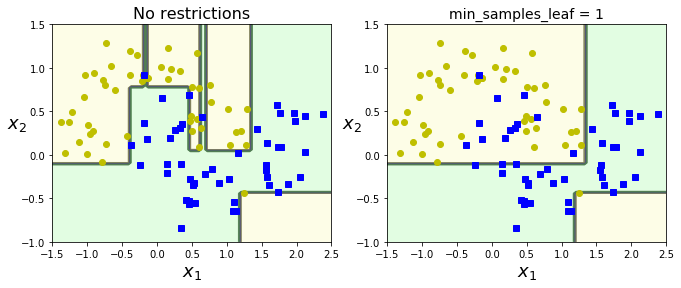

In [0]:
"le jeu de donné moon est un jeu de donné simulé où les deux classes s'emmèlent"
Xm, ym = sklearn.datasets.make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = sklearn.tree.DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.subplot(122)
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)

##  Regression $\hookleftarrow$

Decision Trees are also capable of performing regression tasks. Let’s build a regression tree using Scikit-Learn’s DecisionTreeRegressor class, training it on a noisy quadratic dataset with max_depth=2: 

### Exemple

In [0]:
# data creation
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

tree_reg = sklearn.tree.DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

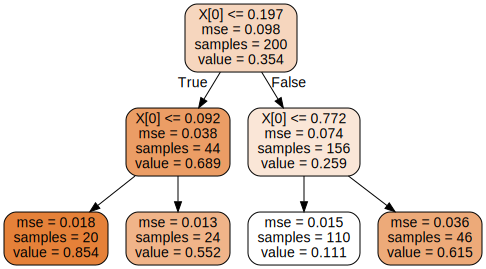

In [0]:
dot_data =sklearn.tree.export_graphviz(
        tree_reg,
        out_file=None,
        rounded=True,
        filled=True
    )

graph = graphviz.Source(dot_data) 
graph

This tree looks very similar to the classification tree you built earlier. The main difference is that instead of predicting a class in each node, it predicts a value. For example, suppose you want to make a prediction for a new instance with `x[0]` = 0.6. You traverse the tree starting at the root, and you eventually reach the leaf node that predicts `value=0.1106`. This prediction is simply the average target value of the 110 training instances associated to this leaf node. This prediction results in a Mean Squared Error (MSE) equal to 0.0151 over these 110 instances. 

### Plot the regression

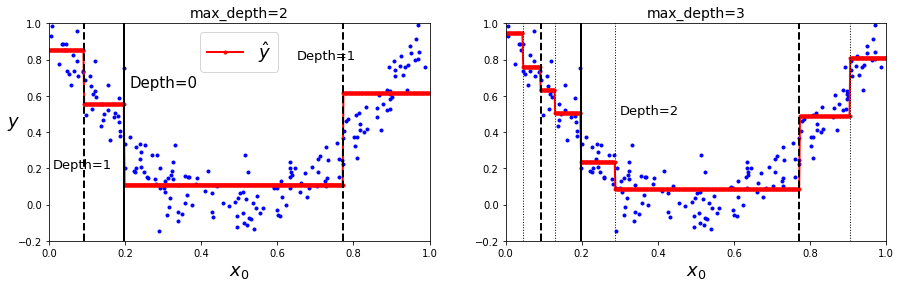

In [0]:
tree_reg1 = sklearn.tree.DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = sklearn.tree.DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel(r"$x_0$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

plt.figure(figsize=(15, 4))
plt.subplot(121)
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.subplot(122)
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14);

### The CART algorithm 

The CART algorithm works mostly the same way as earlier, except that instead of trying to split the training set in a way that minimizes impurity, it now tries to split the training set in a way that minimizes the MSE intra-node. 

The algorithm  splits each set using a single feature and a threshold, which are choosen to minimise:
$$
\frac {m_{\text{left}} } {m} \,  \text{MSE}_{\text{left}} +  \frac {m_{\text{right}} } {m} \,  \text{MSE}_{\text{right}}
$$
where
$$
\text{MSE}_{\text{node}} = \sum_{i \in \text{node}} \big( \bar y_{\text{node}} - y_i \big)^2
$$
where $\bar y_{\text{node}}$ is the mean over the node. 


### Regularization

Just like for classification tasks, Decision Trees are prone to overfitting when dealing with regression tasks. Without any regularization (i.e., using the default hyperparameters) it   overfits the training set very badly. Just setting `min_samples_leaf=10` results in a much more reasonable model. 

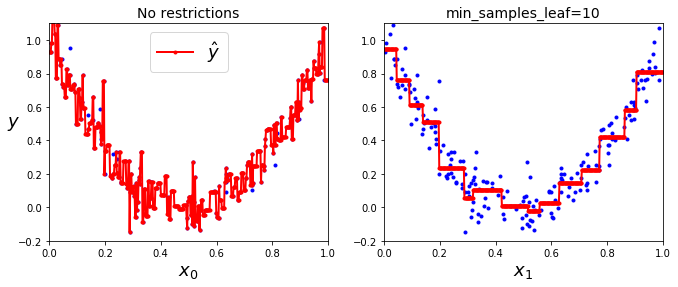

In [0]:
tree_reg1 = sklearn.tree.DecisionTreeRegressor(random_state=42)
tree_reg2 = sklearn.tree.DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel(r"$x_0$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.subplot(122)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14);

##  Instability $\hookleftarrow$



### Data rotation

Hopefully by now you are convinced that Decision Trees have a lot going for them: they are simple to understand and interpret, easy to use, versatile, and powerful. However they do have a few limitations. First, as you may have noticed, Decision Trees love orthogonal decision boundaries (all splits are perpendicular to an axis), which makes them sensitive to training set rotation. For example, here is a simple linearly separable dataset: on the left, a Decision Tree can split it easily, while on the right, after the dataset is rotated by 45°, the decision boundary looks unnecessarily convoluted. 

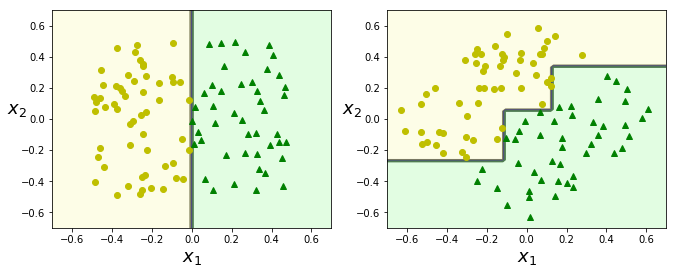

In [0]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = sklearn.tree.DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = sklearn.tree.DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.subplot(122)
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False);

Although both Decision Trees fit the training set perfectly, it is very likely that the model on the right will not generalize well. One way to limit this problem is to use PCA, which often results in a better orientation of the training data.

### small variations

More generally, the main issue with Decision Trees is that they are very sensitive to small variations in the training data. For example, if you just remove the widest Iris-Versicolor from the iris training set (the one with petals 4.8 cm long and 1.8 cm wide) and train a new Decision Tree, you may get the model represented in Figure 6-8. As you can see, it looks very different from the previous Decision Tree (Figure 6-2). Actually, since the training algorithm used by Scikit-Learn is stochastic you may get very different models even on the same training data (unless you set the random_state hyperparameter).  Random Forests can limit this instability by averaging predictions over many trees. 

Text(1.0, 1.8, 'Depth=1')

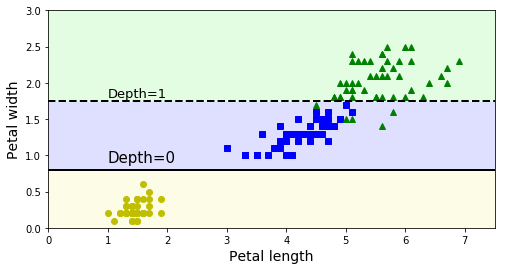

In [0]:
iris = sklearn.datasets.load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target
X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)] # widest Iris-Versicolor flower
not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = sklearn.tree.DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)